In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
df = pd.read_csv('msr_paraphrase_train.csv', on_bad_lines='skip')

sentences1 = df['#1 String'].fillna("").astype(str).values
sentences2 = df['#2 String'].fillna("").astype(str).values
labels = df['Quality'].values
# print(sentences1[:10])

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate((sentences1, sentences2), axis=0))
vocab_size = len(tokenizer.word_index) + 1

max_len = 100  # Adjust as needed
seq1 = pad_sequences(tokenizer.texts_to_sequences(sentences1), maxlen=max_len)
seq2 = pad_sequences(tokenizer.texts_to_sequences(sentences2), maxlen=max_len)

In [4]:
def create_cnn_model(vocab_size, max_len):
    input1 = Input(shape=(max_len,))
    input2 = Input(shape=(max_len,))
    
    embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)
    
    # CNN Layer
    conv = Conv1D(filters=128, kernel_size=5, activation='relu')
    pooling = GlobalMaxPooling1D()
    
    # First branch
    x1 = embedding(input1)
    x1 = conv(x1)
    x1 = pooling(x1)
    
    # Second branch
    x2 = embedding(input2)
    x2 = conv(x2)
    x2 = pooling(x2)
    
    # Concatenate
    merged = Concatenate()([x1, x2])
    merged = Dropout(0.5)(merged)
    
    # Dense layers
    dense = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[input1, input2], outputs=output)
    return model

In [5]:
class TrainingMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self, 'metrics'):
            self.metrics = {
                'loss': [], 'accuracy': [],
                'compression_quality': [], 'frame_rate': [],
                'original_scale': [], 'counter_text_scale': [],
                'original_text_size': [], 'test_result_size': [],
                'operation_count': [], 'pitch_count_likelihood': [],
                'full_frame_size': []
            }
        self.metrics['loss'].append(logs['loss'])
        self.metrics['accuracy'].append(logs['accuracy'])
        
        # Simulate 'compression quality' and 'frame rate' metrics
        self.metrics['compression_quality'].append(1 / (1 + epoch * 0.1))
        self.metrics['frame_rate'].append(10 / (1 + epoch * 0.1))
        
        # Original and counter text scales as dummy values
        self.metrics['original_scale'].append(100 + epoch * 5)
        self.metrics['counter_text_scale'].append(100 + epoch * 5 + np.random.randint(-3, 3))

         # Simulate original vs. test result sizes for each epoch
        self.metrics['original_text_size'].append(50 + epoch * 5)
        self.metrics['test_result_size'].append(45 + epoch * 5 + np.random.randint(-3, 3))
        self.metrics['full_frame_size'].append(100 + epoch * 3)
        
        # Simulate operation count and pitch count likelihood
        self.metrics['operation_count'].append(epoch + 1)
        self.metrics['pitch_count_likelihood'].append(1 / (1 + np.exp(-0.5 * (epoch + 1 - 5))))

# Instantiate and compile the model as in the previous code snippet
model = create_cnn_model(vocab_size, max_len)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callback for metrics collection
metrics_callback = TrainingMetrics()

# Train the model with the callback
history = model.fit([seq1, seq2], labels, epochs=10, batch_size=32, callbacks=[metrics_callback])

C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.6751 - loss: 0.6302
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.7312 - loss: 0.5225
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9264 - loss: 0.2188
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9741 - loss: 0.0816
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9887 - loss: 0.0416
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9950 - loss: 0.0207
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9958 - loss: 0.0178
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9997 - loss: 0.0046
Epoch 9/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9990 - loss: 0.0043
Epoch 10/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9966 - loss: 0.0161


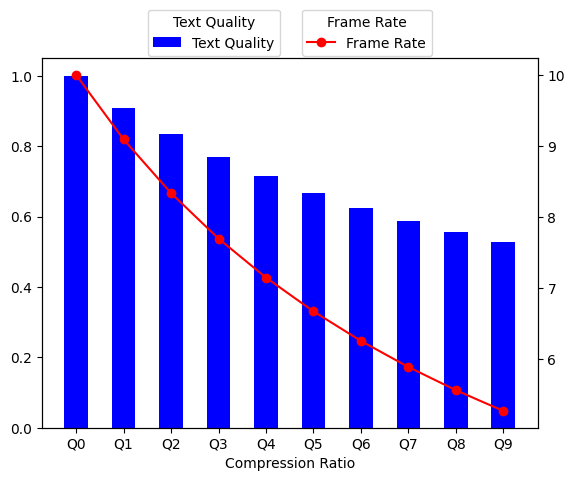

In [10]:
# Graph 1: Histogram (Text quality) + line graph (Frame rate)
metrics = metrics_callback.metrics
epochs = np.arange(1, len(metrics['compression_quality']) + 1)

# Plot Text Quality as a histogram
fig, ax1 = plt.subplots()
ax1.bar(epochs, metrics['compression_quality'], color='blue', width=0.5, label='Text Quality')
ax2 = ax1.twinx()
ax2.plot(epochs, metrics['frame_rate'], color='red', marker='o', linestyle='-', label='Frame Rate')

# Set x-axis labels
ax1.set_xticks(epochs)
ax1.set_xticklabels([f"Q{i}" for i in range(len(epochs))])

# Set labels and title
ax1.set_xlabel("Compression Ratio")
ax1_legend = ax1.legend(loc='upper left', bbox_to_anchor=(0.2, 1.15), title='Text Quality')
ax2_legend = ax2.legend(loc='upper right', bbox_to_anchor=(0.8, 1.15), title='Frame Rate')
fig.savefig('f-02.png', format='png', dpi=1200)
plt.show()

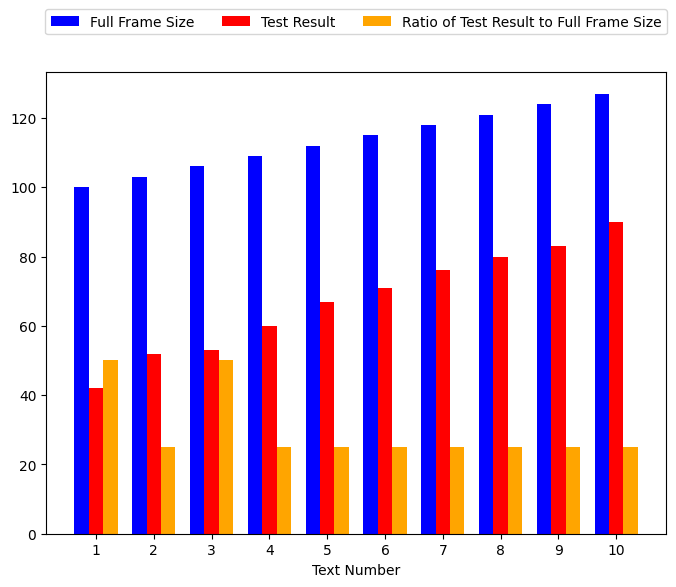

In [11]:
# Graph 2: Histogram Full frame size, Test Result, ratio of test result to full frame size 
bar_width = 0.25
fig, ax = plt.subplots(figsize=(8, 6))
ratio = [(x//y)*25  for x,y in zip(metrics['full_frame_size'], metrics['test_result_size'])]
# Full Frame Size (blue)
ax.bar(epochs - bar_width, metrics['full_frame_size'], color='blue', width=bar_width, label='Full Frame Size')

# Test Result (red)
ax.bar(epochs, metrics['test_result_size'], color='red', width=bar_width, label='Test Result')

# Ratio of Test Result to Full Frame Size (yellow)
ax.bar(epochs + bar_width, ratio, color='orange', width=bar_width, label='Ratio of Test Result to Full Frame Size')

# Set x-axis labels and title
ax.set_xlabel("Text Number")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i) for i in epochs])

# Set legends on top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
fig.savefig('f-03.png', format='png', dpi=1200)
# Show plot
plt.show()


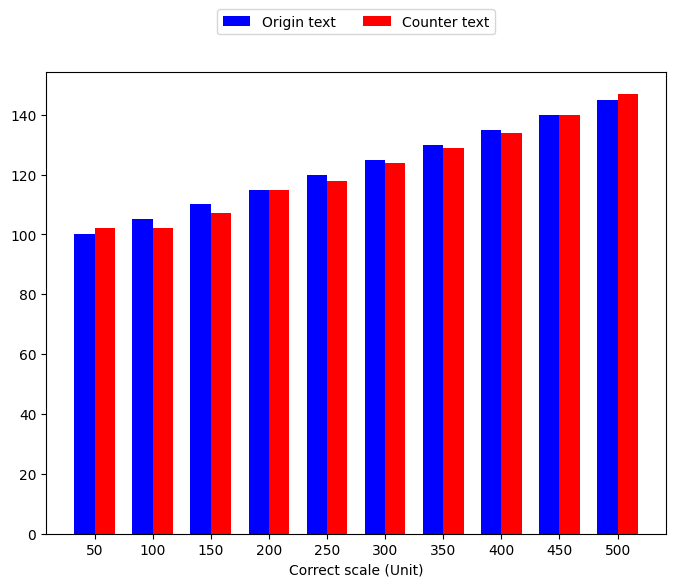

In [12]:
# Graph 3: Histogram original text, counter text
bar_width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(epochs - bar_width/2, metrics['original_scale'], color='blue', width=bar_width, label='Origin text')
ax.bar(epochs + bar_width/2, metrics['counter_text_scale'], color='red', width=bar_width, label='Counter text')

ax.set_xlabel("Correct scale (Unit)")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i*50) for i in epochs])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
fig.savefig('f-04.png', format='png', dpi=1200)
plt.show()

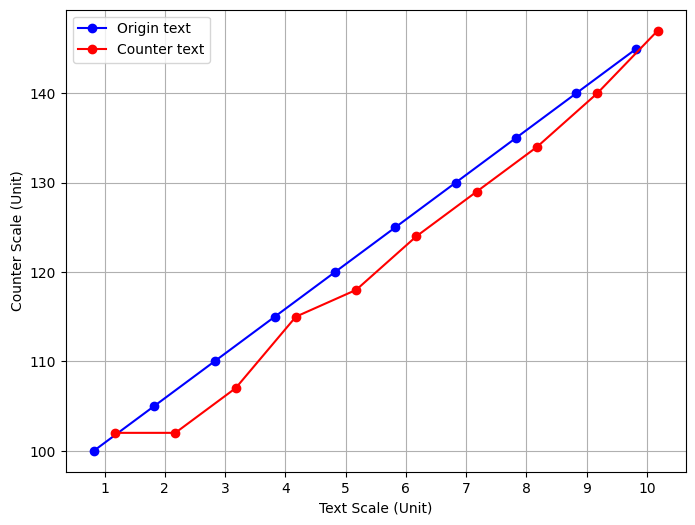

In [9]:
# Graph 4: Line chart original text, Counter text
bar_width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs - bar_width/2, metrics['original_scale'], color='blue', marker="o", label='Origin text')
ax.plot(epochs + bar_width/2, metrics['counter_text_scale'], color='red', marker="o", label='Counter text')

ax.set_xlabel("Text Scale (Unit)")
ax.set_ylabel("Counter Scale (Unit)")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i) for i in epochs])
ax.grid(True)

# Add the legend
ax.legend(loc='upper left')
fig.savefig('f-05.png', format='png', dpi=1200)
plt.show()